In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
import torch
import time
from sklearn.model_selection import train_test_split

curr_directory = os.getcwd()
#
#
#
# Create index for all players + roster dictionaries
#
#
# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))
#
#
#
# Data Processing
#
#
#
# Game data from 2014 - 2015 season to 2017-2018 season
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

# game has chronical order and Y shows score differential, X plus is team 1 payer
# X minus is team 2 player
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

unique_dates = list(set(dates))

# Makes an index of all games that are repeated
repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]
#
#
#
# Game data from the 2018-2019 season and the 2019-2020 season
game_data_2018 = pd.read_csv(os.path.join(curr_directory,'data_sets/game_data_2018_2019.csv'))
game_data_2019 = pd.read_csv(os.path.join(curr_directory,'data_sets/game_data_2019_2020.csv'))

# Strip the day of week abbreviation from Date
game_data_2018['Date'] = game_data_2018['Date'].str[4:]
game_data_2019['Date'] = game_data_2019['Date'].str[4:]

# Date conversion functions
def monthToNum(shortMonth):
    return{
            'Jan' : '01',
            'Feb' : '02',
            'Mar' : '03',
            'Apr' : '04',
            'May' : '05',
            'Jun' : '06',
            'Jul' : '07',
            'Aug' : '08',
            'Sep' : '09', 
            'Oct' : '10',
            'Nov' : '11',
            'Dec' : '12'
    }[shortMonth]

def convert_dates(dataframe): 
    for i in range(dataframe['Date'].shape[0]): 
        if len(dataframe['Date'][i]) == 10: 
            year = dataframe['Date'][i][6:10]
            date = '0' + dataframe['Date'][i][4]
            month = monthToNum(dataframe['Date'][i][0:3])
            dataframe.loc[i, 'Date'] = year + '-' + month + '-' + date
        else: 
            year = dataframe['Date'][i][7:11]
            date = dataframe['Date'][i][4:6]
            month = monthToNum(dataframe['Date'][i][0:3])
            dataframe.loc[i, 'Date'] = year + '-' + month + '-' + date

convert_dates(game_data_2018)
convert_dates(game_data_2019)

game_results_2018 = np.array(list(game_data_2018['Visitor PTS'] - game_data_2018['Home PTS']))
teams_2018 = np.array(list(zip(game_data_2018.Visitor, game_data_2018.Home)))
dates_2018 = np.array(list(game_data_2018['Date']))

game_results_2019 = np.array(list(game_data_2019['Visitor PTS'] - game_data_2019['Home PTS']))
teams_2019 = np.array(list(zip(game_data_2019.Visitor, game_data_2019.Home)))
dates_2019 = np.array(list(game_data_2019['Date']))
#
#
#
# Combine all data into one dataset
#
#
#
teams_all = np.concatenate((unique_teams, teams_2018, teams_2019), axis=0)
dates_all = np.concatenate((unique_dates, dates_2018, dates_2019), axis=0)
results_all = np.concatenate((unique_game_results, game_results_2018, game_results_2019), axis=0)

In [2]:
num_players = 963

def process_data(teams, dates, results): 
    num_games = teams.shape[0]

    # Create x for all games
    # To access x for 0th game -- x[0, :] 
    x_without_intercept = np.zeros((num_games, 2*num_players))

    for i in range(num_games): 
        z, t = x_for_game(teams[i], dates[i])
        combined = np.vstack((z, t))
        x_without_intercept[i, :] = combined[:, 0]

    #x = self.add_intercept(x_without_intercept)
    x = x_without_intercept

    # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
    y = np.zeros((num_games, 1))
    for i in range(num_games): 
        if results[i] > 0: 
            y[i] = 1
        else:
            y[i] = 0

    return x, y

def x_for_game(teams, date): 
    x_1 = np.zeros((num_players, 1))
    x_2 = np.zeros((num_players, 1))

    if int(date[5:7]) < 9: 
        year = str(int(date[0:4]) - 1)
    else: 
        year = date[0:4]

    team_1_players = roster[teams[0]][year]
    for item in team_1_players: 
        x_1[player_index[item]] = 1

    team_2_players = roster[teams[1]][year]
    for item in team_2_players: 
        x_2[player_index[item]] = 1

    return x_1, x_2

In [53]:
x, y = process_data(teams_all, dates_all, results_all)
y = y.reshape((y.shape[0]))

x_train_dev, x_test, y_train_dev, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
x_train, x_dev, y_train, y_dev = train_test_split(x_train_dev, y_train_dev, test_size=0.20, random_state=12)

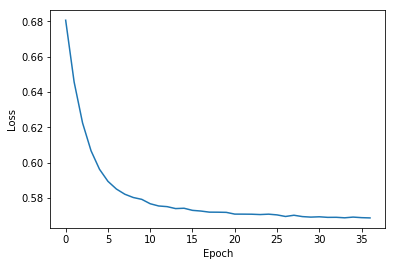

In [4]:
classifier_1 = MLPClassifier(solver='adam', hidden_layer_sizes = (40,) , activation = 'logistic')
classifier_1.fit(x_train, y_train)
plt.plot(classifier_1.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [6]:
print('Training Error: {}'.format(classifier_1.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_1.score(x_test, y_test)))

Training Error: 0.7098076923076924
Validation Error: 0.6556495003843198


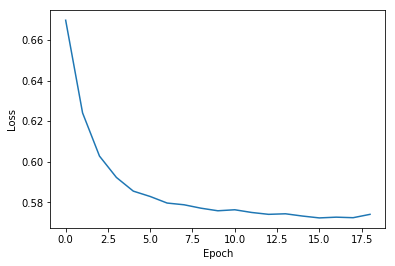

Training Error: 0.7042307692307692
Validation Error: 0.6487317448116833


In [7]:
classifier_2 = MLPClassifier(solver='adam', hidden_layer_sizes = (100,) , activation = 'logistic')
classifier_2.fit(x_train, y_train)
plt.plot(classifier_2.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_2.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_2.score(x_test, y_test)))

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


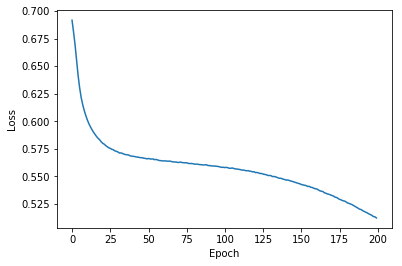

Training Error: 0.79
Validation Error: 0.6464258262874711


In [8]:
classifier_3 = MLPClassifier(solver='adam', hidden_layer_sizes = (40,2) , activation = 'logistic')
classifier_3.fit(x_train, y_train)
plt.plot(classifier_3.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_3.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_3.score(x_test, y_test)))

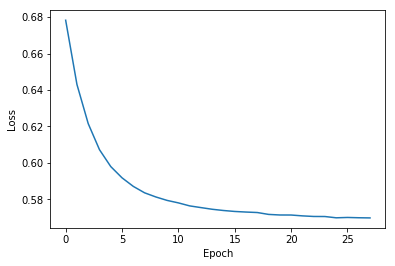

Training Error: 0.7092307692307692
Validation Error: 0.6541122213681784


In [9]:
classifier_4 = MLPClassifier(solver='adam', hidden_layer_sizes = (25,) , activation = 'logistic')
classifier_4.fit(x_train, y_train)
plt.plot(classifier_4.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_4.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_4.score(x_test, y_test)))

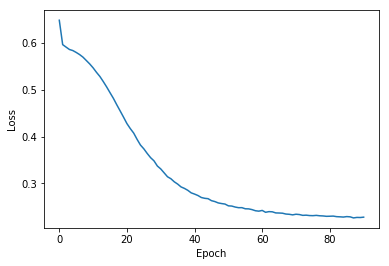

Training Error: 0.8734615384615385
Validation Error: 0.5910837817063798


In [11]:
classifier_4.learning_rate_init = 0.01
classifier_4.fit(x_train, y_train)
plt.plot(classifier_4.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_4.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_4.score(x_test, y_test)))

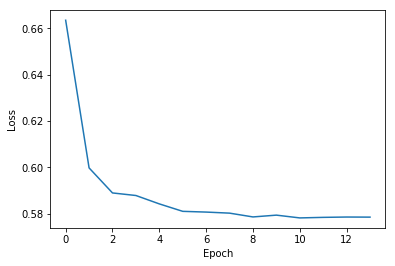

Training Error: 0.7040384615384615
Validation Error: 0.6464258262874711


In [12]:
classifier_5 = MLPClassifier(solver='adam', hidden_layer_sizes = (963,) , activation = 'logistic')
classifier_5.fit(x_train, y_train)
plt.plot(classifier_5.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_5.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_5.score(x_test, y_test)))

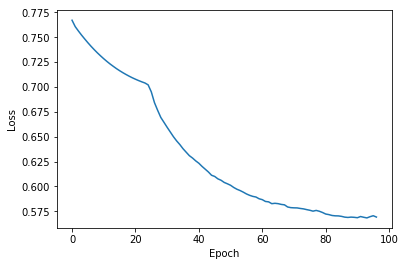

Training Error: 0.724423076923077
Validation Error: 0.6256725595695619


In [13]:
classifier_6 = MLPClassifier(solver='adam', hidden_layer_sizes = (963, 1) , activation = 'logistic')
classifier_6.fit(x_train, y_train)
plt.plot(classifier_6.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_6.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_6.score(x_test, y_test)))

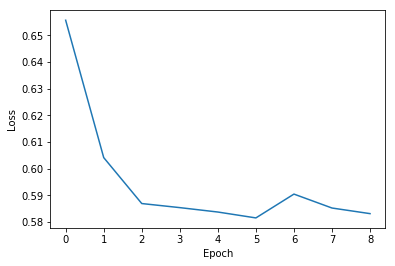

Training Error: 0.6836538461538462
Validation Error: 0.6456571867794004


In [14]:
classifier_7 = MLPClassifier(solver='adam', hidden_layer_sizes = (964, ) , activation = 'logistic')
classifier_7.fit(x_train, y_train)
plt.plot(classifier_7.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_7.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_7.score(x_test, y_test)))

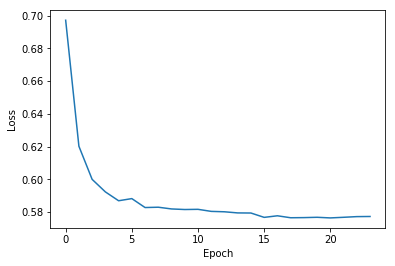

Training Error: 0.7090384615384615
Validation Error: 0.6502690238278247


In [17]:
classifier_8 = MLPClassifier(solver='adam', hidden_layer_sizes = (964, ) , activation = 'tanh')
classifier_8.fit(x_train, y_train)
plt.plot(classifier_8.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_8.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_8.score(x_test, y_test)))

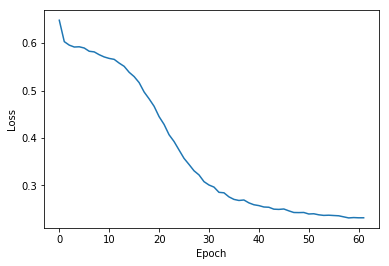

Training Error: 0.8767307692307692
Validation Error: 0.6026133743274404


In [18]:
classifier_9 = MLPClassifier(solver='adam', hidden_layer_sizes = (256, 256) , activation = 'tanh')
classifier_9.fit(x_train, y_train)
plt.plot(classifier_9.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_9.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_9.score(x_test, y_test)))

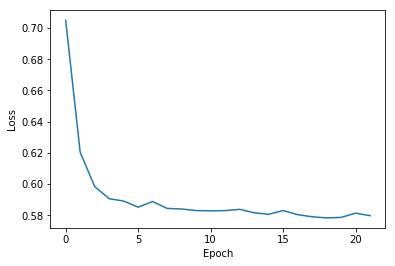

Training Error: 0.705
Validation Error: 0.6425826287471176


In [19]:
classifier_10 = MLPClassifier(solver='adam', hidden_layer_sizes = (1927,) , activation = 'tanh')
classifier_10.fit(x_train, y_train)
plt.plot(classifier_10.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_10.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_10.score(x_test, y_test)))

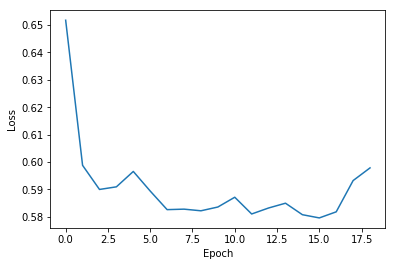

Training Error: 0.6913461538461538
Validation Error: 0.6502690238278247


In [21]:
classifier_11 = MLPClassifier(solver='adam', hidden_layer_sizes = (1927,) , activation = 'logistic')
classifier_11.fit(x_train, y_train)
plt.plot(classifier_11.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_11.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_11.score(x_test, y_test)))

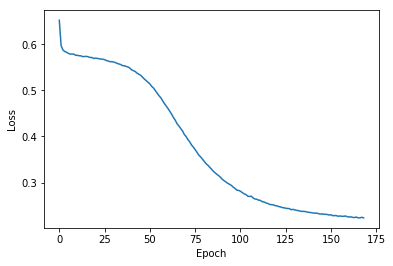

Training Error: 0.8767307692307692
Validation Error: 0.6072252113758647


In [22]:
classifier_12 = MLPClassifier(solver='adam', hidden_layer_sizes = (25,) , activation = 'tanh')
classifier_12.fit(x_train, y_train)
plt.plot(classifier_12.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_12.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_12.score(x_test, y_test)))

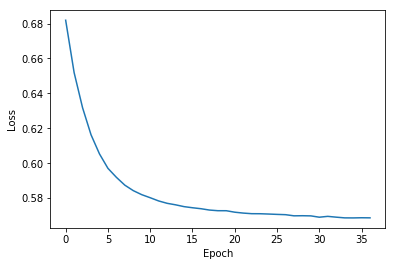

Training Error: 0.7101923076923077
Validation Error: 0.6571867794004612


In [23]:
classifier_13 = MLPClassifier(solver='adam', hidden_layer_sizes = (20,) , activation = 'logistic')
classifier_13.fit(x_train, y_train)
plt.plot(classifier_13.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_13.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_13.score(x_test, y_test)))

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


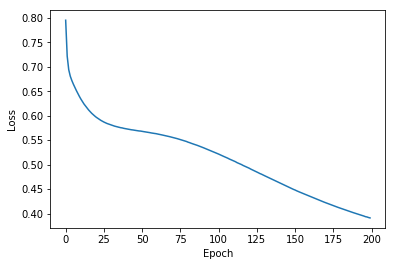

Training Error: 0.8217307692307693
Validation Error: 0.6225980015372791


In [24]:
classifier_14 = MLPClassifier(solver='adam', hidden_layer_sizes = (10,) , activation = 'logistic')
classifier_14.fit(x_train, y_train)
plt.plot(classifier_14.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_14.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_14.score(x_test, y_test)))

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


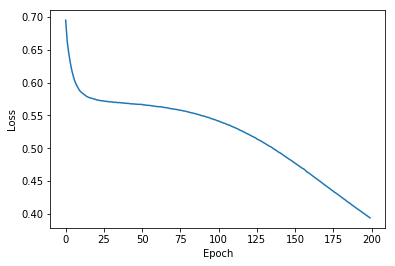

Training Error: 0.8253846153846154
Validation Error: 0.6356648731744812


In [25]:
classifier_15 = MLPClassifier(solver='adam', hidden_layer_sizes = (15,) , activation = 'logistic')
classifier_15.fit(x_train, y_train)
plt.plot(classifier_15.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print('Training Error: {}'.format(classifier_15.score(x_train, y_train)))
print('Validation Error: {}'.format(classifier_15.score(x_test, y_test)))

In [31]:
from sklearn.model_selection import GridSearchCV

parameters = {'solver': ['adam'], 'hidden_layer_sizes': [(5), (10), (15), (20), (25), (5, 5), (5, 10), (5, )], 'activation':['logistic']}
clf = GridSearchCV(MLPClassifier(), parameters)
clf.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'solver': ['lbfgs'], 'hidden_layer_sizes': [5, 10, 15, 20, 25], 'activation': ['logistic']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [54]:
values = [5, 10, 15, 20, 25, 30, 35, 40]

train_accuracies = np.zeros((8, 8))
dev_accuracies = np.zeros((8, 8))
test_accuracies = np.zeros((8, 8))

for i in values: 
    for j in values: 
        grid_classifier = MLPClassifier(solver='adam', hidden_layer_sizes = (i, j) , activation = 'logistic')
        grid_classifier.fit(x_train, y_train)
        train_accuracies[int(i/5 - 1), int(j/5 - 1)] = grid_classifier.score(x_train, y_train)
        dev_accuracies[int(i/5 - 1), int(j/5 - 1)] = grid_classifier.score(x_dev, y_dev)
        test_accuracies[int(i/5 - 1), int(j/5 - 1)] = grid_classifier.score(x_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


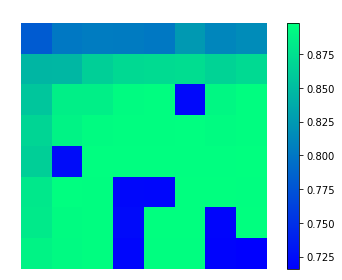

In [57]:
fig, ax = plt.subplots()
im = ax.matshow(train_accuracies, cmap='winter')
cbar = fig.colorbar(im)

fig.tight_layout()
plt.axis('off')
plt.savefig('nn_train_acc.png', dpi = 300)
plt.show()

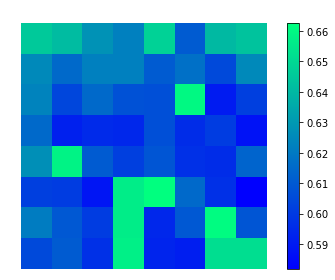

In [58]:
fig, ax = plt.subplots()
im = ax.matshow(dev_accuracies, cmap='winter')
cbar = fig.colorbar(im)

fig.tight_layout()
plt.axis('off')
plt.savefig('nn_dev_acc.png', dpi = 300)
plt.show()

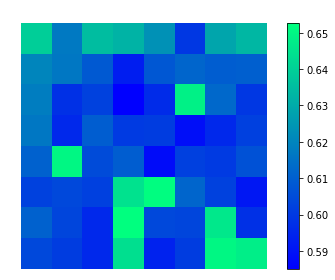

In [59]:
fig, ax = plt.subplots()
im = ax.matshow(test_accuracies, cmap='winter')
cbar = fig.colorbar(im)

fig.tight_layout()
plt.axis('off')
plt.savefig('nn_test_acc.png', dpi = 300)
plt.show()

In [60]:
print(dev_accuracies)

[[0.64519231 0.64134615 0.62788462 0.62211538 0.64807692 0.61057692
  0.64038462 0.64326923]
 [0.625      0.61538462 0.62211538 0.62211538 0.61057692 0.61730769
  0.60480769 0.625     ]
 [0.62307692 0.60384615 0.61538462 0.60769231 0.60673077 0.66057692
  0.59038462 0.60192308]
 [0.61538462 0.59230769 0.59519231 0.59423077 0.60673077 0.59615385
  0.60096154 0.5875    ]
 [0.62692308 0.65865385 0.61057692 0.60192308 0.60865385 0.59711538
  0.59615385 0.61346154]
 [0.60192308 0.60096154 0.58846154 0.65673077 0.6625     0.61538462
  0.59711538 0.58173077]
 [0.62115385 0.60961538 0.60096154 0.65673077 0.59423077 0.60961538
  0.66153846 0.60865385]
 [0.60480769 0.61057692 0.59711538 0.65769231 0.59326923 0.59134615
  0.65192308 0.65192308]]


In [61]:
print(test_accuracies)

[[0.63950807 0.61721752 0.63489623 0.63259032 0.62336664 0.59953882
  0.62874712 0.63335895]
 [0.62029208 0.61644889 0.60876249 0.59262106 0.60799385 0.61183705
  0.60953113 0.61029977]
 [0.61798616 0.59800154 0.60261337 0.58493467 0.59646426 0.64873174
  0.61260569 0.59953882]
 [0.61644889 0.59569562 0.60953113 0.60030746 0.6010761  0.58877786
  0.59569562 0.60184473]
 [0.61106841 0.65026902 0.60491929 0.60953113 0.58800922 0.60184473
  0.60030746 0.60645657]
 [0.60261337 0.60415065 0.60184473 0.64488855 0.6518063  0.61183705
  0.60261337 0.59108378]
 [0.61106841 0.60338201 0.59569562 0.65257494 0.60415065 0.60338201
  0.64642583 0.59800154]
 [0.60415065 0.6010761  0.59569562 0.64411991 0.59415834 0.6010761
  0.65026902 0.64796311]]


In [70]:
values = [5, 10, 15, 20, 25, 30, 35, 40]

train_accuracies_sgd = np.zeros((8, 8))
dev_accuracies_sgd = np.zeros((8, 8))
test_accuracies_sgd = np.zeros((8, 8))

for i in values: 
    for j in values: 
        grid_classifier_sgd = MLPClassifier(solver='sgd', hidden_layer_sizes = (i, j) , activation = 'logistic', learning_rate = 'adaptive')
        grid_classifier_sgd.fit(x_train, y_train)
        train_accuracies_sgd[int(i/5 - 1), int(j/5 - 1)] = grid_classifier_sgd.score(x_train, y_train)
        dev_accuracies_sgd[int(i/5 - 1), int(j/5 - 1)] = grid_classifier_sgd.score(x_dev, y_dev)
        test_accuracies_sgd[int(i/5 - 1), int(j/5 - 1)] = grid_classifier_sgd.score(x_test, y_test)

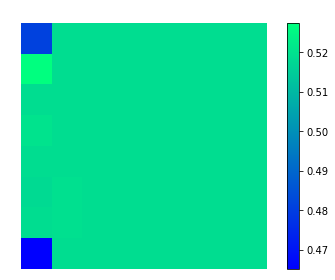

In [71]:
fig, ax = plt.subplots()
im = ax.matshow(test_accuracies_sgd, cmap='winter')
cbar = fig.colorbar(im)

fig.tight_layout()
plt.axis('off')
#plt.savefig('nn_train_acc.png', dpi = 300)
plt.show()

In [72]:
print(dev_accuracies_sgd)

[[0.46730769 0.53269231 0.53269231 0.53269231 0.53269231 0.53269231
  0.53269231 0.53269231]
 [0.54134615 0.53269231 0.53269231 0.53269231 0.53269231 0.53269231
  0.53269231 0.53269231]
 [0.53269231 0.53269231 0.53269231 0.53269231 0.53269231 0.53269231
  0.53269231 0.53269231]
 [0.52692308 0.53269231 0.53269231 0.53269231 0.53269231 0.53269231
  0.53269231 0.53269231]
 [0.53269231 0.53269231 0.53269231 0.53269231 0.53269231 0.53269231
  0.53269231 0.53269231]
 [0.54423077 0.53173077 0.53269231 0.53269231 0.53269231 0.53269231
  0.53269231 0.53269231]
 [0.53269231 0.53269231 0.53269231 0.53269231 0.53269231 0.53269231
  0.53269231 0.53269231]
 [0.48461538 0.53269231 0.53269231 0.53269231 0.53269231 0.53269231
  0.53269231 0.53269231]]


In [81]:
single_values = [10, 20, 30, 40, 50, 100, 964]

#sl = single layer
sl_train_accuracies = np.zeros(7)
sl_dev_accuracies = np.zeros(7)
sl_test_accuracies = np.zeros(7)

for i in range(len(single_values)): 
    sl_grid_classifier = MLPClassifier(solver='adam', hidden_layer_sizes = (single_values[i], ) , activation = 'logistic')
    sl_grid_classifier.fit(x_train, y_train)
    sl_train_accuracies[i] = sl_grid_classifier.score(x_train, y_train)
    sl_dev_accuracies[i] = sl_grid_classifier.score(x_dev, y_dev)
    sl_test_accuracies[i] = sl_grid_classifier.score(x_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [82]:
print(sl_train_accuracies)
print(sl_dev_accuracies)
print(sl_test_accuracies)

[0.81370192 0.84375    0.71225962 0.715625   0.71370192 0.71009615
 0.70913462]
[0.64230769 0.6375     0.6625     0.66442308 0.66153846 0.65961538
 0.6625    ]
[0.62567256 0.62567256 0.65026902 0.64950038 0.64488855 0.64873174
 0.64258263]
